In [1]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numba import jit
from scipy.optimize import root_scalar
from pynndescent import NNDescent
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA

In [49]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

In [21]:
@jit
def entropy(d, beta):
    x = - d * beta
    y = np.exp(x)
    ysum = y.sum()
    if ysum < 1e-50:
        return -1.
    else:
        factor = - 1/(np.log(2.) * ysum)
        return factor * ((y * x) - (y * np.log(ysum))).sum()
    
def p_i(d, beta):
    x = - d * beta
    y = np.exp(x)
    ysum = y.sum()
    return y / ysum

def find_beta(d, perp, upper_bound=1e6):
    return root_scalar(
        lambda b: entropy(d, b) - np.log2(perp),
        bracket=(0.,upper_bound)
    ).root

def p_ij_sym(x, perp, verbose=False):
    num_pts = x.shape[0]
    k = min(num_pts - 1, int(3 * perp))
    if verbose:
        print('Indexing')
    index = NNDescent(x, n_neighbors=k)
    neighbors, p_ij = index.neighbor_graph
    neighbors = neighbors[:,1:]
    p_ij = p_ij[:,1:]
    # neighbors = np.empty((num_pts, k-1), dtype=np.int)
    # p_ij = np.empty((num_pts, k-1))
    for i, xi in enumerate(x):
        if verbose:
            print('Calculating probabilities: {cur}/{tot}'.format(
                cur=i+1, tot=num_pts), end='\r')
        beta = find_beta(p_ij[i], perp)
        p_ij[i] = p_i(p_ij[i], beta)
    row_indices = np.repeat(np.arange(num_pts), k-1)
    p = csr_matrix((p_ij.ravel(), (row_indices, neighbors.ravel())))
    return 0.5*(p + p.transpose())

def dist_mat_squared(x):
    batch_size = x.shape[0] 
    expanded = x.unsqueeze(1)
    tiled = torch.repeat_interleave(expanded, batch_size, dim=1)
    diffs = tiled - tiled.transpose(0, 1)
    sum_act = torch.sum(torch.pow(diffs,2), axis=2)    
    return sum_act

def norm_sym(x):
    x.fill_diagonal_(0.)
    norm_facs = x.sum(axis=0, keepdim=True)
    x = x / norm_facs
    return 0.5*(x + x.t())

def q_ij(x, alpha):
    dists = dist_mat_squared(x)
    q = torch.pow((1 + dists/alpha), -(alpha+1)/2)
    return norm_sym(q)

def kullback_leibler_loss(p, q, eps=1.0e-7):
    eps = torch.tensor(eps, dtype=p.dtype)
    kl_matr = torch.mul(p, torch.log(p + eps) - torch.log(q + eps))
    kl_matr.fill_diagonal_(0.)    
    return torch.sum(kl_matr)

def submatrix(m, indices):
    dim = len(indices)
    indices = np.array(np.meshgrid(indices, indices)).T.reshape(-1,2).T
    return torch.tensor(m[indices[0], indices[1]].reshape(dim, dim))

In [22]:
class ParametricTSNE(nn.Module):
    
    def __init__(self, input_dim, output_dim, perp,
                 alpha=1.0,
                 hidden_layer_dims=None,
                 seed=None,
                 use_cuda=False):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.perplexity = perp
        self.alpha = alpha
        
        self.use_cuda = use_cuda
        
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        # If no layers provided, use the same architecture as van der maaten 2009 paper
        if hidden_layer_dims is None:
            hidden_layer_dims = [500, 500, 2000]
        
        self.layers = nn.ModuleList()
        
        cur_dim = input_dim
        for hdim in hidden_layer_dims:
            self.layers.append(nn.Linear(cur_dim, hdim))
            cur_dim = hdim
        self.layers.append(nn.Linear(cur_dim, output_dim))
        
        if self.alpha == 'learn':
            self.alpha = nn.Parameter(torch.tensor(1.))
        
        if self.use_cuda:
            self.cuda()
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            # x = torch.sigmoid(layer(x))
            x = F.softplus(layer(x))
        out = self.layers[-1](x)
        return out
    
    def pretrain(self, training_data,
            epochs=10,
            verbose=False,
            batch_size=500,
            learning_rate=0.01):
        if verbose:
            print('Calculating PCA')

        if type(training_data) is torch.Tensor:
            pca = torch.tensor(PCA(n_components=2).fit_transform(training_data.detach().cpu().numpy()))
        else:
            pca = torch.tensor(PCA(n_components=2).fit_transform(training_data))

        dataset = torch.utils.data.TensorDataset(training_data, pca)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        
        if verbose:
            print('{time}: Beginning pretraining for {epochs} epochs'.format(
                time=datetime.datetime.now(),
                epochs=epochs))
        
        for epoch in range(epochs):
            running_loss = 0
            for batch, data in enumerate(dataloader):
                
                features, targets = data
                    
                if self.use_cuda:
                    features = features.cuda()
                    targets = targets.cuda()
                    
                optim.zero_grad()
                
                loss = criterion(self(features), targets)
                
                loss.backward()
                optim.step()
                    
                running_loss += loss.item()
                
            if verbose:
                print('{time}: Loss after epoch {ep}: {rloss}'.format(
                    time=datetime.datetime.now(),
                    ep=epoch,
                    rloss=running_loss))

        if verbose:
            print('{time}: Finished pretraining'.format(
                time=datetime.datetime.now()))
        
    def fit(self, training_data,
            loss_func='kl',
            p_ij=None,
            pretrain=False,
            epochs=10,
            verbose=False,
            optimizer=torch.optim.Adam,
            batch_size=500,
            learning_rate=0.01):
        
        assert training_data.shape[1] == self.input_dim, "Input training data must be same shape as training `num_inputs`"
        
        self.p_ij = p_ij
        self._epochs = epochs
        
        if pretrain:
            self.pretrain(training_data, epochs=5, verbose=verbose, batch_size=batch_size)
        
        if self.p_ij is None:
            self.p_ij = p_ij_sym(training_data.detach().cpu().numpy(), self.perplexity, verbose=verbose).toarray()
            
        dataset = torch.utils.data.TensorDataset(training_data, torch.arange(training_data.shape[0]))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optim = optimizer(self.parameters(), lr=learning_rate)
        
        if verbose:
            print('{time}: Beginning training for {epochs} epochs'.format(
                time=datetime.datetime.now(),
                epochs=epochs))
            
        loss_func = {
            'kl': kullback_leibler_loss#,
            # 'kl_rev': kullback_leibler_reverse_loss,
            # 'js': jensen_shannon_loss,
            # 'frob': frobenius_loss,
            # #'bat': bhattacharyya_loss,
            # 'tot': total_variational_loss
        }[loss_func]
        
        for epoch in range(epochs):
            running_loss = 0
            for batch, data in enumerate(dataloader):
                
                features, indices = data
                
                p = submatrix(self.p_ij, indices.numpy())
                p = p / p.sum()
                
                if epoch < 10:
                    # exaggeration test
                    exaggeration = 10.
                    p *= exaggeration
                    
                if self.use_cuda:
                    features = features.cuda()
                    p = p.cuda()
                    
                optim.zero_grad()
                
                q = q_ij(self(features), self.alpha)
                q = q / q.sum()
                
                loss = loss_func(p, q)
                
                if epoch < 10:
                   # exaggeration tets
                   loss = loss / exaggeration - np.log(exaggeration)
                
                loss.backward()
                optim.step()
                    
                running_loss += loss.item()
                
            if verbose:
                print('{time}: Loss after epoch {ep}: {rloss}'.format(
                    time=datetime.datetime.now(),
                    ep=epoch+1,
                    rloss=running_loss))

        if verbose:
            print('{time}: Finished training'.format(
                time=datetime.datetime.now()))

In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [4]:
mnist = MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

In [26]:
testdata = mnist.data.reshape(-1, 28*28) / 255.
testdata = testdata[:2000]

In [45]:
tsne = ParametricTSNE(28*28, 2, 100)

In [46]:
tsne.fit(testdata, pretrain=True, verbose=True, epochs=25)

Calculating PCA
2022-01-31 14:26:28.507203: Beginning pretraining for 5 epochs
2022-01-31 14:26:28.839232: Loss after epoch 0: 21415.327872753143
2022-01-31 14:26:29.172505: Loss after epoch 1: 35.37024164199829
2022-01-31 14:26:29.492364: Loss after epoch 2: 23.416386604309082
2022-01-31 14:26:29.817043: Loss after epoch 3: 18.36772108078003
2022-01-31 14:26:30.143093: Loss after epoch 4: 17.322229385375977
2022-01-31 14:26:30.143093: Finished pretraining
Indexing
2022-01-31 14:26:32.710740: Beginning training for 25 epochs
2022-01-31 14:26:33.225350: Loss after epoch 1: 10.762358665466309
2022-01-31 14:26:33.776518: Loss after epoch 2: 9.359306812286377
2022-01-31 14:26:34.311910: Loss after epoch 3: 8.129131317138672
2022-01-31 14:26:34.863702: Loss after epoch 4: 7.494322299957275
2022-01-31 14:26:35.397370: Loss after epoch 5: 6.870521068572998
2022-01-31 14:26:35.939189: Loss after epoch 6: 6.610375642776489
2022-01-31 14:26:36.487972: Loss after epoch 7: 6.3304123878479
2022-01-

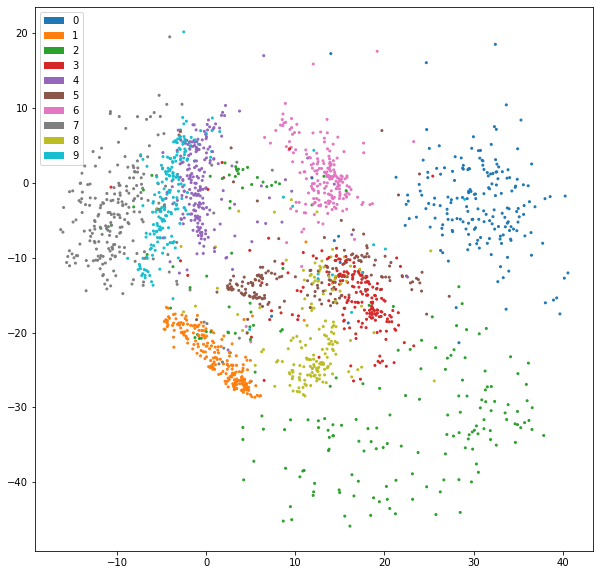

In [50]:
x,y = tsne(testdata).detach().t()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist.targets[:2000]]
#colors = [plt.cm.tab10.colors[i] for i in np.repeat(np.arange(3),50)]
ax.scatter(x,y,c=colors, s=4)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

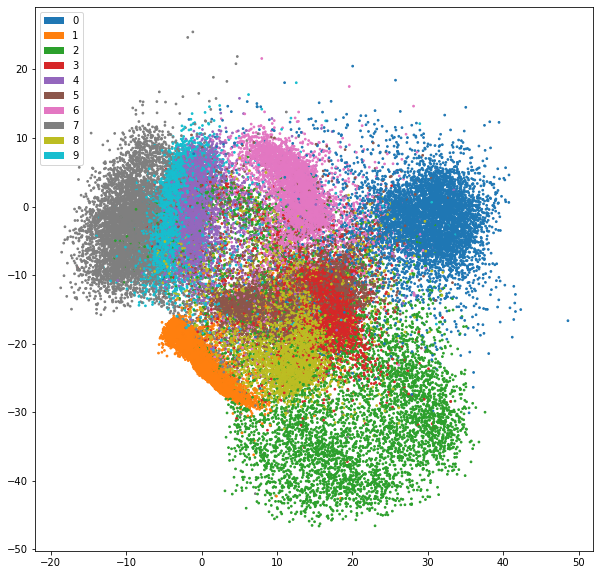

In [53]:
x,y = tsne(mnist.data[2000:].reshape(-1,28*28)/255.).detach().t()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist.targets[2000:]]
#colors = [plt.cm.tab10.colors[i] for i in np.repeat(np.arange(3),50)]
ax.scatter(x,y,c=colors, s=3)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [195]:
class ParametricSupervisedTSNE(nn.Module):
    
    def __init__(self, input_dim, output_dim, num_classes, perp,
                 alpha=1.0,
                 hidden_layer_dims=None,
                 seed=None,
                 use_cuda=False):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.perplexity = perp
        self.alpha = alpha
        self.num_classes= num_classes
        
        self.use_cuda = use_cuda
        
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        # If no layers provided, use the same architecture as van der maaten 2009 paper
        if hidden_layer_dims is None:
            hidden_layer_dims = [500, 500, 2000]
        
        self.layers = nn.ModuleList()
        
        cur_dim = input_dim
        for hdim in hidden_layer_dims:
            self.layers.append(nn.Linear(cur_dim, hdim))
            cur_dim = hdim
        self.layers.append(nn.Linear(cur_dim, output_dim))

        self.class_layer = nn.Linear(cur_dim, num_classes)
        
        if self.alpha == 'learn':
            self.alpha = nn.Parameter(torch.tensor(1.))
        
        if self.use_cuda:
            self.cuda()
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            # x = torch.sigmoid(layer(x))
            x = F.softplus(layer(x))
        out_dr = self.layers[-1](x)
        out_class = F.softmax(self.class_layer(x), dim=1)
        return (out_dr, out_class)
    
    def pretrain(self, training_data,
            epochs=10,
            verbose=False,
            batch_size=500,
            learning_rate=0.01):
        if verbose:
            print('Calculating PCA')

        if type(training_data) is torch.Tensor:
            pca = torch.tensor(PCA(n_components=2).fit_transform(training_data.detach().cpu().numpy()))
        else:
            pca = torch.tensor(PCA(n_components=2).fit_transform(training_data))

        dataset = torch.utils.data.TensorDataset(training_data, pca)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        
        if verbose:
            print('{time}: Beginning pretraining for {epochs} epochs'.format(
                time=datetime.datetime.now(),
                epochs=epochs))
        
        for epoch in range(epochs):
            running_loss = 0
            for batch, data in enumerate(dataloader):
                
                features, targets = data
                    
                if self.use_cuda:
                    features = features.cuda()
                    targets = targets.cuda()
                    
                optim.zero_grad()
                
                loss = criterion(self(features)[0], targets)
                
                loss.backward()
                optim.step()
                    
                running_loss += loss.item()
                
            if verbose:
                print('{time}: Loss after epoch {ep}: {rloss}'.format(
                    time=datetime.datetime.now(),
                    ep=epoch,
                    rloss=running_loss))

        if verbose:
            print('{time}: Finished pretraining'.format(
                time=datetime.datetime.now()))
        
    def fit(self, training_data,
            class_labels,
            weight=0.5,
            loss_func='kl',
            p_ij=None,
            pretrain=False,
            epochs=10,
            verbose=False,
            optimizer=torch.optim.Adam,
            batch_size=500,
            learning_rate=0.01):
        
        assert training_data.shape[1] == self.input_dim, "Input training data must be same shape as training `num_inputs`"
        
        self.p_ij = p_ij
        self._epochs = epochs
        
        if pretrain:
            self.pretrain(training_data, epochs=5, verbose=verbose, batch_size=batch_size)
        
        if self.p_ij is None:
            self.p_ij = p_ij_sym(training_data.detach().cpu().numpy(), self.perplexity, verbose=verbose).toarray()
            
        dataset = torch.utils.data.TensorDataset(training_data, torch.arange(training_data.shape[0]), class_labels)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optim = optimizer(self.parameters(), lr=learning_rate)
        
        if verbose:
            print('{time}: Beginning training for {epochs} epochs'.format(
                time=datetime.datetime.now(),
                epochs=epochs))
            
        loss_func = {
            'kl': kullback_leibler_loss#,
            # 'kl_rev': kullback_leibler_reverse_loss,
            # 'js': jensen_shannon_loss,
            # 'frob': frobenius_loss,
            # #'bat': bhattacharyya_loss,
            # 'tot': total_variational_loss
        }[loss_func]

        class_loss = nn.CrossEntropyLoss()
        
        for epoch in range(epochs):
            running_loss = 0
            for batch, data in enumerate(dataloader):
                
                features, indices, targets = data
                
                p = submatrix(self.p_ij, indices.numpy())
                p = p / p.sum()
                
                if epoch < 10:
                    # exaggeration test
                    exaggeration = 10.
                    p *= exaggeration
                    
                if self.use_cuda:
                    features = features.cuda()
                    p = p.cuda()
                    targets = targets.cuda()
                    
                optim.zero_grad()
                
                q = q_ij(self(features)[0], self.alpha)
                q = q / q.sum()
                
                loss = loss_func(p, q) + weight * class_loss(self(features)[1], targets)
                
                if epoch < 10:
                   # exaggeration tets
                   loss = loss / exaggeration - np.log(exaggeration)
                
                loss.backward()
                optim.step()
                    
                running_loss += loss.item()
                
            if verbose:
                print('{time}: Loss after epoch {ep}: {rloss}'.format(
                    time=datetime.datetime.now(),
                    ep=epoch+1,
                    rloss=running_loss))

        if verbose:
            print('{time}: Finished training'.format(
                time=datetime.datetime.now()))

In [146]:
sup_tsne = ParametricSupervisedTSNE(28*28, 2, 10, 100,
    alpha=1.,
    hidden_layer_dims=[100,100,50],
    use_cuda=True
)

In [150]:
sup_tsne.fit(testdata.cuda(), mnist.targets[:2000].cuda(),
    weight=0.1,
    pretrain=True,
    epochs=25,
    # verbose=True,
    # p_ij=p_ij_mnist
)

Calculating PCA
2022-01-31 17:46:07.492806: Beginning pretraining for 5 epochs
2022-01-31 17:46:07.596160: Loss after epoch 0: 237.95692586898804
2022-01-31 17:46:07.693801: Loss after epoch 1: 10.494909286499023
2022-01-31 17:46:07.770392: Loss after epoch 2: 10.592194318771362
2022-01-31 17:46:07.830325: Loss after epoch 3: 9.033687114715576
2022-01-31 17:46:07.886793: Loss after epoch 4: 6.950343489646912
2022-01-31 17:46:07.886793: Finished pretraining
2022-01-31 17:46:07.886793: Beginning training for 25 epochs
2022-01-31 17:46:08.070348: Loss after epoch 1: 7.416560173034668
2022-01-31 17:46:08.276252: Loss after epoch 2: 6.234055280685425
2022-01-31 17:46:08.498658: Loss after epoch 3: 5.744041442871094
2022-01-31 17:46:08.740868: Loss after epoch 4: 5.447209596633911
2022-01-31 17:46:09.053033: Loss after epoch 5: 5.146449327468872
2022-01-31 17:46:09.319048: Loss after epoch 6: 4.900940179824829
2022-01-31 17:46:09.535993: Loss after epoch 7: 4.832434177398682
2022-01-31 17:46

In [ ]:
x,y = sup_tsne(mnist.data[5000:15000].reshape(-1,28*28)/255.)[0].detach().t()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist.targets[5000:15000]]
#colors = [plt.cm.tab10.colors[i] for i in np.repeat(np.arange(3),50)]
ax.scatter(x,y,c=colors, s=3)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [163]:
p_ij_mnist = sup_tsne.p_ij

In [196]:
coords = []
preds = []
for weight in torch.arange(0., 120, 20.):
    print(weight.item())
    sup_tsne = ParametricSupervisedTSNE(28*28, 2, 10, 100,
        alpha=1.,
        hidden_layer_dims=[100, 100, 50],
        use_cuda=True
    )
    sup_tsne.fit(
        (mnist.data[:5000].reshape(-1,28*28)/255.).cuda(),
        mnist.targets[:5000].cuda(),
        weight=weight.item(),
        p_ij=p_ij_mnist,
        pretrain=True,
        epochs=25
    )
    out1, out2 = sup_tsne((mnist.data[:].reshape(-1,28*28)/255.).cuda())
    coords.append(out1.detach().cpu())
    preds.append(out2.detach().cpu())

0.0
20.0
40.0
60.0
80.0
100.0


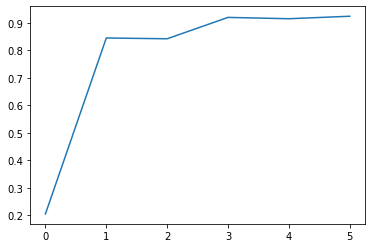

In [197]:
accs = [ torch.sum(i.argmax(dim=1) == mnist.targets)/60000. for i in preds ]
plt.plot(accs)

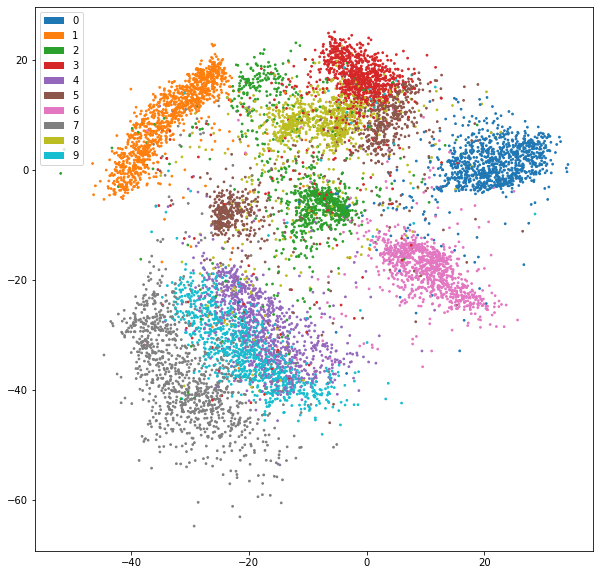

In [198]:
x,y = coords[0][5000:15000].t()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist.targets[5000:15000]]
#colors = [plt.cm.tab10.colors[i] for i in np.repeat(np.arange(3),50)]
ax.scatter(x,y,c=colors, s=3)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

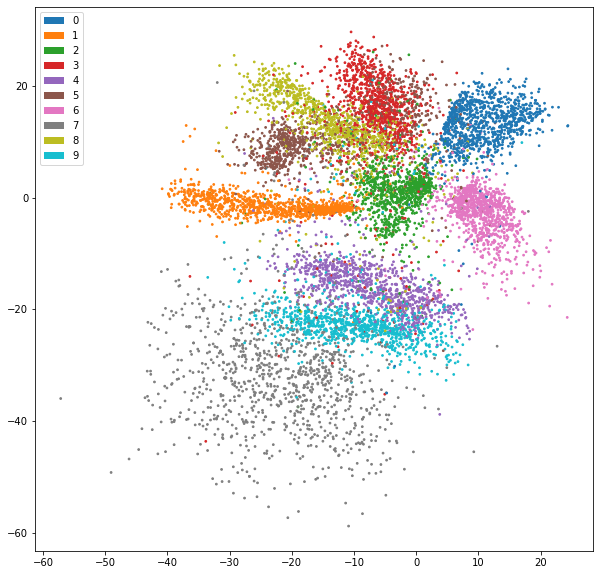

In [202]:
x,y = coords[1][5000:15000].t()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist.targets[5000:15000]]
#colors = [plt.cm.tab10.colors[i] for i in np.repeat(np.arange(3),50)]
ax.scatter(x,y,c=colors, s=3)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

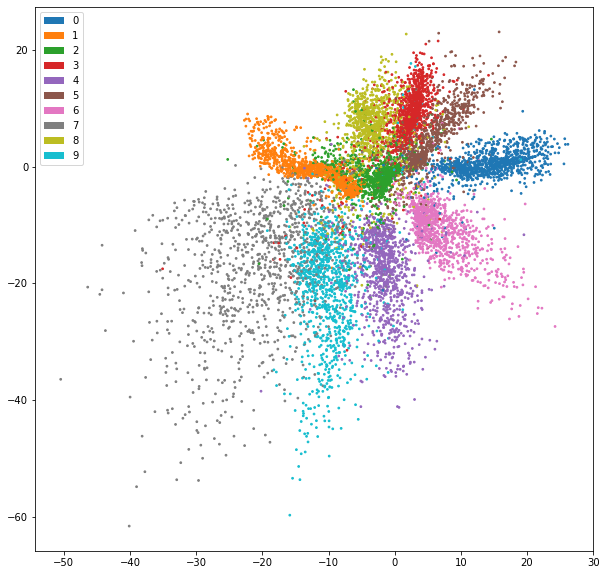

In [203]:
x,y = coords[3][5000:15000].t()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist.targets[5000:15000]]
#colors = [plt.cm.tab10.colors[i] for i in np.repeat(np.arange(3),50)]
ax.scatter(x,y,c=colors, s=3)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [208]:
class LinearTSNE(nn.Module):
    
    def __init__(self, input_dim, output_dim, perp,
                 alpha=1.0,
                 seed=None,
                 use_cuda=False):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.perplexity = perp
        self.alpha = alpha
        
        self.use_cuda = use_cuda
        
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        self.layer = nn.Linear(input_dim, output_dim)
        
        if self.alpha == 'learn':
            self.alpha = nn.Parameter(torch.tensor(1.))
        
        if self.use_cuda:
            self.cuda()
        
    def forward(self, x):
        out = self.layer(x)
        return out
    
    def pretrain(self, training_data,
            epochs=10,
            verbose=False,
            batch_size=500,
            learning_rate=0.01):
        if verbose:
            print('Calculating PCA')

        if type(training_data) is torch.Tensor:
            pca = torch.tensor(PCA(n_components=2).fit_transform(training_data.detach().cpu().numpy()))
        else:
            pca = torch.tensor(PCA(n_components=2).fit_transform(training_data))

        dataset = torch.utils.data.TensorDataset(training_data, pca)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        
        if verbose:
            print('{time}: Beginning pretraining for {epochs} epochs'.format(
                time=datetime.datetime.now(),
                epochs=epochs))
        
        for epoch in range(epochs):
            running_loss = 0
            for batch, data in enumerate(dataloader):
                
                features, targets = data
                    
                if self.use_cuda:
                    features = features.cuda()
                    targets = targets.cuda()
                    
                optim.zero_grad()
                
                loss = criterion(self(features), targets)
                
                loss.backward()
                optim.step()
                    
                running_loss += loss.item()
                
            if verbose:
                print('{time}: Loss after epoch {ep}: {rloss}'.format(
                    time=datetime.datetime.now(),
                    ep=epoch,
                    rloss=running_loss))

        if verbose:
            print('{time}: Finished pretraining'.format(
                time=datetime.datetime.now()))
        
    def fit(self, training_data,
            loss_func='kl',
            p_ij=None,
            pretrain=False,
            epochs=10,
            verbose=False,
            optimizer=torch.optim.Adam,
            batch_size=500,
            learning_rate=0.01):
        
        assert training_data.shape[1] == self.input_dim, "Input training data must be same shape as training `num_inputs`"
        
        self.p_ij = p_ij
        self._epochs = epochs
        
        if pretrain:
            self.pretrain(training_data, epochs=5, verbose=verbose, batch_size=batch_size)
        
        if self.p_ij is None:
            self.p_ij = p_ij_sym(training_data.detach().cpu().numpy(), self.perplexity, verbose=verbose).toarray()
            
        dataset = torch.utils.data.TensorDataset(training_data, torch.arange(training_data.shape[0]))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optim = optimizer(self.parameters(), lr=learning_rate)
        
        if verbose:
            print('{time}: Beginning training for {epochs} epochs'.format(
                time=datetime.datetime.now(),
                epochs=epochs))
            
        loss_func = {
            'kl': kullback_leibler_loss#,
            # 'kl_rev': kullback_leibler_reverse_loss,
            # 'js': jensen_shannon_loss,
            # 'frob': frobenius_loss,
            # #'bat': bhattacharyya_loss,
            # 'tot': total_variational_loss
        }[loss_func]
        
        for epoch in range(epochs):
            running_loss = 0
            for batch, data in enumerate(dataloader):
                
                features, indices = data
                
                p = submatrix(self.p_ij, indices.numpy())
                p = p / p.sum()
                
                if epoch < 10:
                    # exaggeration test
                    exaggeration = 10.
                    p *= exaggeration
                    
                if self.use_cuda:
                    features = features.cuda()
                    p = p.cuda()
                    
                optim.zero_grad()
                
                q = q_ij(self(features), self.alpha)
                q = q / q.sum()
                
                loss = loss_func(p, q)
                
                if epoch < 10:
                   # exaggeration tets
                   loss = loss / exaggeration - np.log(exaggeration)
                
                loss.backward()
                optim.step()
                    
                running_loss += loss.item()
                
            if verbose:
                print('{time}: Loss after epoch {ep}: {rloss}'.format(
                    time=datetime.datetime.now(),
                    ep=epoch+1,
                    rloss=running_loss))

        if verbose:
            print('{time}: Finished training'.format(
                time=datetime.datetime.now()))

In [316]:
ltsne = LinearTSNE(28*28, 2, 100, use_cuda=True)

In [317]:
ltsne.fit((mnist.data[:2000].reshape(-1,28*28)/255.).cuda(), pretrain=True,epochs=25,verbose=True)

Calculating PCA
2022-01-31 22:23:44.761988: Beginning pretraining for 5 epochs
2022-01-31 22:23:44.821438: Loss after epoch 0: 12.044776678085327
2022-01-31 22:23:44.896487: Loss after epoch 1: 3.43332576751709
2022-01-31 22:23:44.960195: Loss after epoch 2: 2.5075566172599792
2022-01-31 22:23:45.012565: Loss after epoch 3: 2.9374247193336487
2022-01-31 22:23:45.062964: Loss after epoch 4: 2.183785229921341
2022-01-31 22:23:45.062964: Finished pretraining
Indexing
2022-01-31 22:23:47.644940: Beginning training for 25 epochs
2022-01-31 22:23:47.751727: Loss after epoch 1: 7.459502696990967
2022-01-31 22:23:47.860713: Loss after epoch 2: 7.223708152770996
2022-01-31 22:23:47.988889: Loss after epoch 3: 7.103886127471924
2022-01-31 22:23:48.118946: Loss after epoch 4: 7.04043436050415
2022-01-31 22:23:48.217723: Loss after epoch 5: 7.019672393798828
2022-01-31 22:23:48.323844: Loss after epoch 6: 6.890319108963013
2022-01-31 22:23:48.415739: Loss after epoch 7: 6.880775690078735
2022-01-3

In [318]:
lcoords = ltsne((mnist.data[:8000].reshape(-1,28*28)/255.).cuda()).detach().cpu()

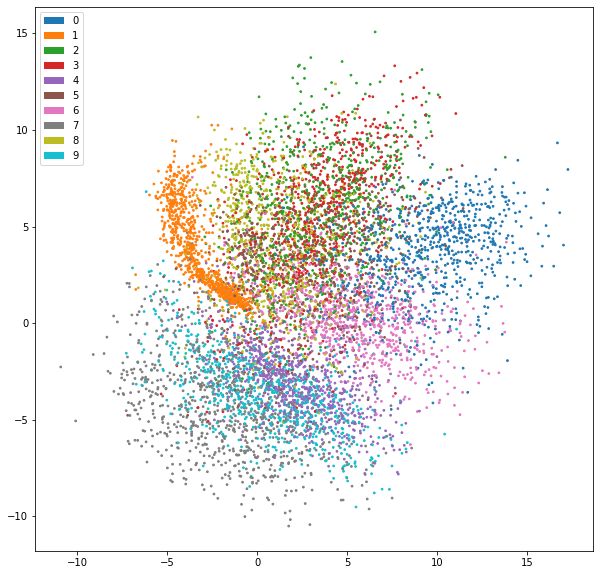

In [319]:
x,y = lcoords.t()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist.targets[:8000]]
#colors = [plt.cm.tab10.colors[i] for i in np.repeat(np.arange(3),50)]
ax.scatter(x,y,c=colors, s=3)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [320]:
wl = ltsne.layer.state_dict()['weight'].detach().cpu()
bl = ltsne.layer.state_dict()['bias'].detach().cpu()

In [321]:
ltsne.requires_grad_(False)

LinearTSNE(
  (layer): Linear(in_features=784, out_features=2, bias=True)
)

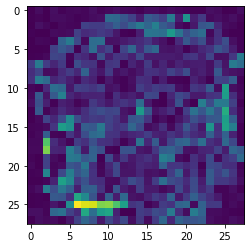

In [237]:
plt.imshow(wl[0].reshape(28, 28).abs())

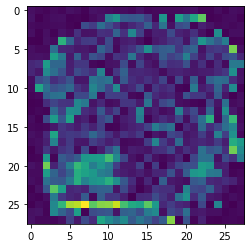

In [238]:
plt.imshow(wl[1].reshape(28, 28).abs())

In [282]:
mnist.data

tensor([[-4.7884,  6.7207],
        [-0.8871,  0.6649],
        [-1.5903,  0.9025],
        ...,
        [-3.0841,  2.3195],
        [-3.8989,  3.9706],
        [-1.7590,  1.3710]])

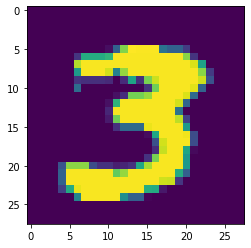

In [343]:
plt.imshow(mnist.data[27].reshape(28,28))

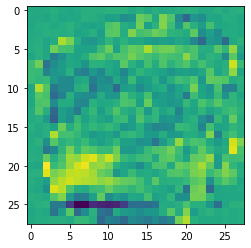

In [345]:
a = (mnist.data[27]/255.).reshape(28*28).clone().detach().cuda().requires_grad_(True)
b = ltsne(a).norm()
b.backward()
plt.imshow(a.grad.detach().cpu().reshape(28,28))

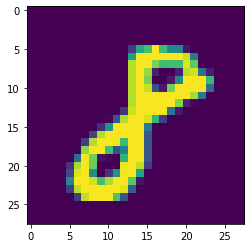

In [374]:
plt.imshow(mnist.data[31].reshape(28,28))

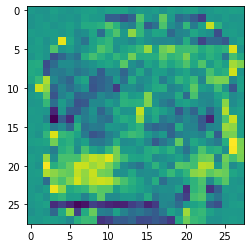

In [375]:
a = (mnist.data[31]/255.).reshape(28*28).clone().detach().cuda().requires_grad_(True)
b = ltsne(a).norm()
b.backward()
plt.imshow(a.grad.detach().cpu().reshape(28,28))